In [36]:
import numpy as np
import re
import string
import pandas as pd

import tensorflow as tf
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.datasets import imdb
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter
import os
import getEmbeddings
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

In [37]:
# Load and inspect data

# load full/subset of the FNC dataset

data = pd.read_csv("FNC_Final.csv", engine = "python", error_bad_lines=False)
# data = pd.read_csv("FNC_Subset.csv")
data.head()

# fill in missing values
data['type'].fillna('unknown',inplace = True)
print(data['type'].describe())

# examine summary stats for 'type' column

print(data.shape)
print(data['type'].describe())
print(data['type'].unique())

data['type'].fillna('unknown',inplace = True)
print(data['type'].describe())
print(data['type'].unique())

count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
(142395, 27)
count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
['fake' 'satire' 'reliable' 'political' 'bias']
count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
['fake' 'satire' 'reliable' 'political' 'bias']


In [38]:
# Remove articles from survey

survey_articles= pd.read_csv('survey_articles.csv')
survey_list= list(survey_articles['id'])
to_delete= list(data[data.id.isin(survey_list)].index)
data[data.id.isin(survey_list)]

# Remove articles from survey

data=data.drop(to_delete,axis=0)
data[data.id.isin(survey_list)]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,domain,type,url,content,scraped_at,inserted_at,...,summary,source,len_content,len_title,num_exclaim_title,num_sentences_content,sentences_content,num_paras,num_punc_content,percent_punc_content_per_len


In [39]:
# examine reliable, satire, fake, etc. articles

reliable = data.loc[data['type'] == 'reliable']
satire = data.loc[data['type'] == 'satire']
fake = data.loc[data['type'] == 'fake']
political = data.loc[data['type'] == 'political']
bias = data.loc[data['type'] == 'bias']

print(type(reliable['type']))
print(len(reliable['type']))
print(type(fake['type']))
print(len(fake['type']))

print(len(satire['type']))
print(len(political['type']))
print(len(bias['type']))

<class 'pandas.core.series.Series'>
47753
<class 'pandas.core.series.Series'>
22280
2863
41166
28332


In [40]:
# select random sample from fake news, then combine reliable and fake news in a new dataframe
import random
fake = fake.sample(n=10000)
reliable = reliable.sample(n=10000)
satire = satire.sample(n=2863)
political = political.sample(n=10000)
bias = bias.sample(n=10000)
print(type(fake))
print(fake.head())

data = reliable.append(fake)
data = data.append(satire)
data = data.append(political)
data = data.append(bias)
data.head()

print(len(reliable['type']))
print(len(fake['type']))
print(len(satire['type']))
print(len(political['type']))
print(len(bias['type']))

<class 'pandas.core.frame.DataFrame'>
       Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1       id             domain  \
43829       80470         80470            1477  3752971  beforeitsnews.com   
26850       53960         53960            3041  2502021  beforeitsnews.com   
80188      142512        142512            3399  6857631  beforeitsnews.com   
54588       99837         99837            9034  4638490  beforeitsnews.com   
74718      135239        135239            3834  6491320  beforeitsnews.com   

       type                                                url  \
43829  fake  http://beforeitsnews.com/gold-and-precious-met...   
26850  fake  http://beforeitsnews.com/alternative/2013/10/a...   
80188  fake  http://beforeitsnews.com/obama-birthplace-cont...   
54588  fake  http://beforeitsnews.com/spirit/2012/04/we-are...   
74718  fake  http://beforeitsnews.com/opinion-conservative/...   

                                                 content  \
43829  Gold Video of the Day: 

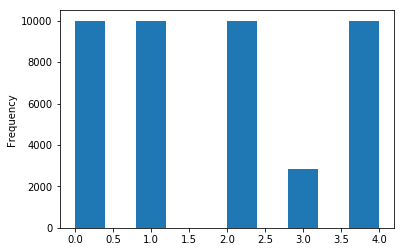

In [41]:
# change "reliable" to 0, change "satire" to 1

data.loc[data['type'] == 'reliable', 'type'] = 0.0
data.loc[data['type'] == 'political', 'type'] = 1.0
data.loc[data['type'] == 'bias', 'type'] = 2.0
data.loc[data['type'] == 'satire', 'type'] = 3.0
data.loc[data['type'] == 'fake', 'type'] = 4.0

#plot the distribution
data['type'].plot.hist()


In [42]:
# split data into train and test

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

train_data = train[['content','type']].copy()
test_data = test[['content','type']].copy()

print(len(train_data))
print(len(test_data))
# print(train_data['type'])
# print(train_data['content'])

34413
8450


In [43]:
def cleanText(text):
    #remove EOL 
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text= text.split(" ")
    
    #remove stop words 
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    arr= np.array(text)
    # preprocess data to standardize lengths
    #text= text[0:999]
        
    #text=' '.join(text)
    
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
    return arr

# remove EOL, stopwords

x_train = np.array(train_data["content"].apply(cleanText))
y_train = np.array(train_data["type"])

x_test = np.array(test_data["content"].apply(cleanText))
y_test = np.array(test_data["type"])
    
print(x_train[0])
print(y_train)
print(type(y_train))

['Baahubali' 'released' 'Tamil' 'Telugu' 'July' '2015' 'became' "India's"
 'biggest-ever' 'hit.' 'The' 'producers' 'blockbuster' 'hit' 'Baahubali'
 'raided' 'homes' 'Hyderabad.' 'Baahubali' ',' 'historical' 'fiction'
 'epic,' 'released' 'simultaneously' 'Tamil' 'Telugu' 'July' '2015'
 'became' "India's" 'biggest-ever' 'hit.' 'The' 'sequel' 'already'
 'announced' 'distribution' 'rights' 'sold' 'whopping' 'amount.The'
 'producers,' 'Shobu' 'Yarlagadda' 'Prasad' 'Devineni,' 'raided' 'today,'
 'allegedly' 'large' 'amounts' 'cash' 'discontinued' 'Rs' '500' 'Rs'
 '1,000' 'notes' 'believed' 'hoarded' 'home.The' 'high-denomination'
 'currency' 'declared' 'illegal' 'Tuesday' 'transactions' 'shock' 'move'
 'Prime' 'Minister' 'Narendra' 'Modi' 'seen' 'audacious' 'attempt' 'check'
 'rampant' 'use' 'black' 'money.Yesterday,' 'raids' 'held' 'four'
 'different' 'cities' 'including' 'Mumbai' 'Delhi,' 'officials'
 'targeting' 'shops' 'jewelers' 'private' 'operators' 'money-launder'
 'illicitly' 'exchan

In [44]:
# pad/truncate the sequences
x_train = pad_sequences(x_train, value= "PAD", dtype=object, padding= 'post', truncating = 'post', maxlen=128)
x_test = pad_sequences(x_test, value= "PAD", dtype=object, padding= 'post', truncating = 'post', maxlen=128)

print(len(x_train[1]))
print(len(x_train))
print(x_train[1])

128
34413
['On' 'Thursday,' 'Feast' 'Immaculate' 'Conception,' 'alternate-side'
 'street-cleaning' 'regulations' 'New' 'York' 'City' 'suspended.' 'Other'
 'regulations' 'remain' 'effect.' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD']


In [45]:
# convert list of tokens, to list of strings

def tok_to_str(tokens):
    text = []
    for x in tokens:
        text.append(TreebankWordDetokenizer().detokenize(x))
    return text
    
x_train = tok_to_str(x_train)
x_test = tok_to_str(x_test)

print(len(x_train))
print(x_train[1])

34413
On Thursday, Feast Immaculate Conception, alternate-side street-cleaning regulations New York City suspended. Other regulations remain effect. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [46]:
# save files
np.save('xtr_shuffled.npy',x_train)
np.save('xte_shuffled.npy',x_test)
np.save('ytr_shuffled.npy',y_train)
np.save('yte_shuffled.npy',y_test)

In [47]:
top_words = 5000
epoch_num = 10
batch_size = 128

In [48]:
# Read the text data
# if not os.path.isfile('./xtr_shuffled.npy') or \
#     not os.path.isfile('./xte_shuffled.npy') or \
#     not os.path.isfile('./ytr_shuffled.npy') or \
#     not os.path.isfile('./yte_shuffled.npy'):
#     getEmbeddings.clean_data()

In [49]:
xtr = np.load('./xtr_shuffled.npy')
xte = np.load('./xte_shuffled.npy')
y_train = np.load('./ytr_shuffled.npy')
y_test = np.load('./yte_shuffled.npy')

In [50]:
cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

In [51]:
# Storing most common words

most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

In [52]:
# Encode train sentences

for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(y_train)
y_test = list(y_test)

In [53]:
# Delete the short news

i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

In [54]:
# Generate test data

x_test = []
for x in xte:
    x_test.append(x.split())

In [55]:
# Encode test sentences

for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

In [56]:
# Truncate and pad input sequences

max_review_length = 128
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  425  488 1029  609    2 4761  599 2505 2549
  425  488 1029  609    2  216  352  581 1346 1368 1981  526 3792 1701
 2081 3539 2887 1534 3228 1752  875  475 3941  521  890  520  364 1064
 1405   60  496  399  206  401 2011   43  326 4257  587 1956  109 2887
  683 1359  139  531  349  197  979   11 2081 2887 1925 1359 1056 1259
    1    1]


In [57]:
# Convert to numpy arrays

y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train[0:5])

[0 0 0 0 0]


# create attention layer

In [58]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(max_review_length)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features):
        score = tf.nn.tanh(self.W(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [59]:
context_vector, attention_weights = Attention(x_train)

TypeError: 'Attention' object is not iterable

In [60]:
# Create the model

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)


W0805 05:17:16.574238 140333765494528 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 05:17:16.576295 140333765494528 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 05:17:16.579938 140333765494528 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 05:17:16.903016 140333765494528 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 05:17:16.927062 140333765494528 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           160064    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 213,769
Trainable params: 213,769
Non-trainable params: 0
_________________________________________________________________
None


W0805 05:17:18.020229 140333765494528 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 34383 samples, validate on 8450 samples
Epoch 1/10
34383/34383 [==============================] - 73s 2ms/step - loss: 1.3264 - acc: 0.4171 - val_loss: 1.0108 - val_acc: 0.5893
Epoch 2/10
34383/34383 [==============================] - 73s 2ms/step - loss: 0.8898 - acc: 0.6410 - val_loss: 0.8603 - val_acc: 0.6812
Epoch 3/10
34383/34383 [==============================] - 71s 2ms/step - loss: 0.7424 - acc: 0.7246 - val_loss: 0.7754 - val_acc: 0.7130
Epoch 4/10
34383/34383 [==============================] - 70s 2ms/step - loss: 0.6309 - acc: 0.7551 - val_loss: 0.7378 - val_acc: 0.7140
Epoch 5/10
34383/34383 [==============================] - 69s 2ms/step - loss: 0.6196 - acc: 0.7581 - val_loss: 0.7787 - val_acc: 0.6820
Epoch 6/10
34383/34383 [==============================] - 69s 2ms/step - loss: 0.5599 - acc: 0.7829 - val_loss: 0.7100 - val_acc: 0.7421
Epoch 7/10
34383/34383 [==============================] - 72s 2ms/step - loss: 0.5072 - acc: 0.8019 - val_loss: 0.6697 - val_acc:

In [61]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

Accuracy= 75.35%


/home/jupyter/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/jupyter/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


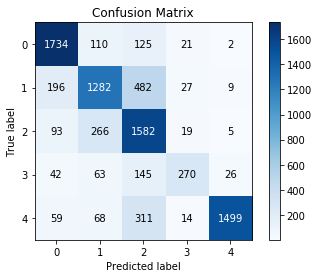

In [62]:
# Draw the confusion matrix

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

    
y_pred = model.predict_classes(X_test)
plot_cmat(y_test, y_pred)